In [13]:
from __future__ import division, print_function
import numpy as np
from numpy import inf, ndarray
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
import random
import sklearn
import re
from tempfile import TemporaryFile
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
from functools import partial
from multiprocessing import cpu_count, Pool
import math 
import networkx as nx
#from networkx.drawing.nx_agraph import graphviz_layout
from argparse import Namespace
import ast
import pickle
import json
import pygraphviz as pgv
import pydot

from tqdm.auto import tqdm
import sys
import seaborn as sns
sns.set()

# Load data

In [2]:
emb=pd.read_csv('final_plots_mcs/g2v_embeddings_clusters.csv',index_col=0)

In [3]:
clustered_graphs=emb[['cluster','sig_id']]

In [4]:
graphs_location='/home/biolab/Documents/deepsnem_drive/data/graphs_weighted/'
unw_loc='/home/biolab/Documents/deepsnem_drive/data/graphs_combined/'

In [5]:
list(graphs_location+clustered_graphs['sig_id']+'/graph.csv')[0]

'/home/biolab/Documents/deepsnem_drive/data/graphs_weighted/AML001_CD34_24H_BRD-A19500257_1.11111/graph.csv'

# Maximum common subgraph for lists

In [6]:
def df_to_nx(df):
    flag=False
    net=nx.DiGraph()
    nodes=list(set(list(df['node1']) + list(df['node2'])))
    if "Perturbation" not in nodes:
        nodes.append("Perturbation")
        flag=True
    for i in range(len(nodes)):
        if ((nodes[i]=="Perturbation") and flag):
            net.add_node(nodes[i],act=0)
        elif nodes[i] in list(df['node1']):
            j=list(df['node1']).index(nodes[i])
            a=list(df['activity1'])[j]
            net.add_node(nodes[i],act=a)
        else:
            j=list(df['node2']).index(nodes[i])
            a=list(df['activity2'])[j]
            net.add_node(nodes[i],act=a)
    for i in range(len(df)):
        net.add_edge(df['node1'][i], df['node2'][i], weight=df['sign'][i])
    
    return(net)

In [7]:
def df_to_nx(df):
    import numpy as np
    flag=False
    net=nx.DiGraph()
    for i in range(len(df)):
        ##if ((df['weight'][i]>=0.5) or (df['node1'][i]=='Perturbation')):
        net.add_edge(df['node1'][i], df['node2'][i], weight=df['sign'][i]*df['weight'][i])
    nodes=list(net.nodes())
    if "Perturbation" not in nodes:
        nodes.append("Perturbation")
        roots=np.setdiff1d(list(set(list(df['node1']))),list(set(list(df['node2']))))
        for i in range(len(roots)):
            ind=list(df['node1']).index(roots[i])
            a=float(list(df['upact1'])[ind])-float(list(df['downact1'])[ind])
            sign = lambda x: 1 if (abs(x)==x) else -1
            net.add_edge("Perturbation", roots[i], weight=sign(a))
        flag=True
    for i in range(len(nodes)):
        if ((nodes[i]=="Perturbation") and flag):
            net.nodes[nodes[i]].update({'act':0})
        elif nodes[i] in list(df['node1']):
            j=list(df['node1']).index(nodes[i])
            a=float(list(df['upact1'])[j])-float(list(df['downact1'])[j])
            net.nodes[nodes[i]].update({'act':a})
        else:
            j=list(df['node2']).index(nodes[i])
            a=float(list(df['upact2'])[j])-float(list(df['downact2'])[j])
            net.nodes[nodes[i]].update({'act':a})
    return(net)

In [8]:
nets_paths=list(graphs_location+clustered_graphs['sig_id']+'/graph.csv')
unw_paths=list(unw_loc+clustered_graphs['sig_id']+'/')
graph_df=[pd.read_csv(x,index_col=0).reset_index(drop=True) for x in nets_paths]
nets=[df_to_nx(x) for x in graph_df]

# Na to kano san to average diktio tou carnival

In [87]:
def getMFS(G_list,unweigthed_folders,activity_thresh=0.3,edge_freq=0.6):
    c=0
    unique_nodes={}
    unique_edges={}
    for j,G in enumerate(G_list):
        no_of_graphs=len(os.listdir(unweigthed_folders[j]))
        c=c+no_of_graphs
        for n in G.nodes():
            if (n in unique_nodes.keys()):
                unique_nodes[n].append(G.nodes(data=True)[n]['act']*no_of_graphs)
            else:
                unique_nodes.update({n:[G.nodes(data=True)[n]['act']*no_of_graphs]})
        for n1,n2,attr in G.edges(data=True):
            inter=n1+'_'+n2
            if (inter in unique_edges.keys()):
                unique_edges[inter].append(attr['weight']*no_of_graphs)
            else:
                unique_edges.update({inter:[attr['weight']*no_of_graphs]})
        
    #build most frequent subgraph
    net=nx.DiGraph()
    for k in unique_nodes.keys():
        unique_nodes[k]=sum(unique_nodes[k])/c
        if abs(unique_nodes[k])>=activity_thresh:
            net.add_node(k,act=unique_nodes[k])
    for k in unique_edges.keys():
        unique_edges[k]=sum(unique_edges[k])/c
        n1=k.split('_')[0]
        n2=k.split('_')[1]
        if ((abs(unique_edges[k])>=edge_freq) and (n1 in net.nodes) and (n2 in net.nodes)):
            net.add_edge(n1,n2,weight=unique_edges[k])
    
    #remove lone nodes
    lone_nodes=list(nx.isolates(net))
    for n in lone_nodes:
        net.remove_node(n)
    graphs = list(nx.connected_components(net.to_undirected(reciprocal=False, as_view=True)))
    if (len(graphs)>1):
        max_len=0
        for i,g in enumerate(graphs):
            if len(g)>=max_len:
                max_len=len(g)
                id=i
        graphs=graphs[0:id]+graphs[id+1:]
        to_rem=[]
        for g in graphs:
            if type(g)==set:
                to_rem=to_rem+list(g)
            else:
                to_rem.append(g)
        #print(to_rem)
        to_rem=list(set(to_rem))
        for n in to_rem:
            net.remove_node(n)
 
    return {'max_length':len(list(net.nodes)),'MFS':net}

In [88]:
#Create json file format
def net2json(net):
    feats={}
    for n,attr in net.nodes(data=True):
        feats.update({n:attr['act']})
    json_net={}
    json_net.update({"edges":[]})
    json_net.update({"nodes":feats})
    for n1,n2,attr in net.edges(data=True):
        json_net["edges"].append([n1,n2,attr['weight']])
    return(json_net)

# Find for each cluster the maximum common subgraph

In [89]:
cls=list(range(1,20))
net_list=[]
for cl in cls:
    ind=list(clustered_graphs['cluster'][clustered_graphs['cluster']==cl].index)
    clustered_nets=[nets[x-1] for x in ind]
    res=getMFS(clustered_nets,unw_paths)
    print(res['max_length'])
    net_list.append(res['MFS'])
    #jnet=net2json(res['MFS'])
    #with open('final_plots_mcs/cluster_%s.json'%cl, 'w') as fp:
        #json.dump(jnet, fp)
    #fp.close()
    

5
2
3
2
8
9
3
6
2
2
4
2
2
4
4
13
2
3
0


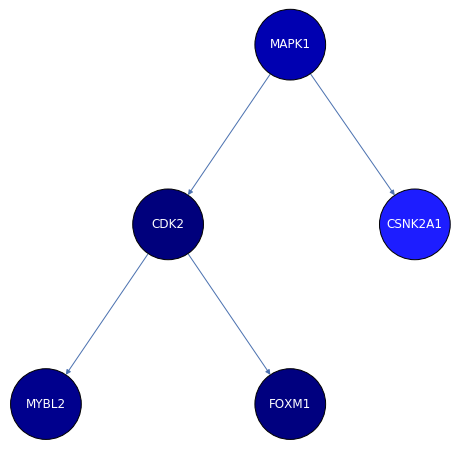

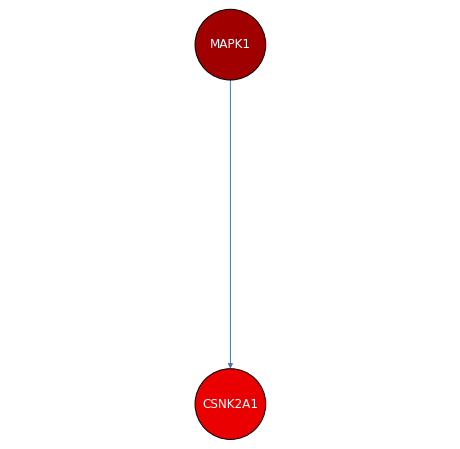

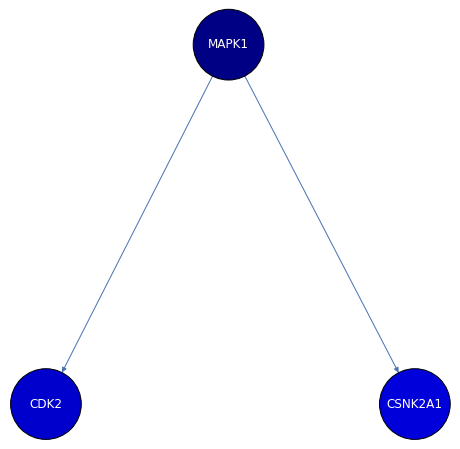

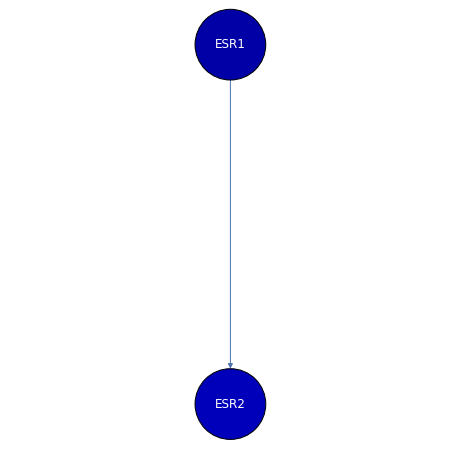

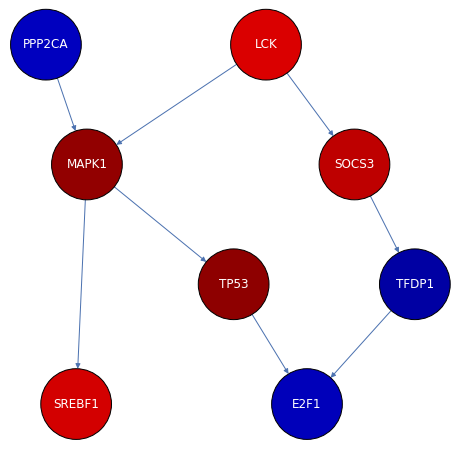

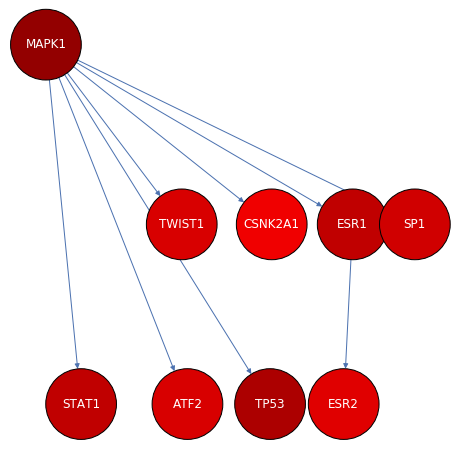

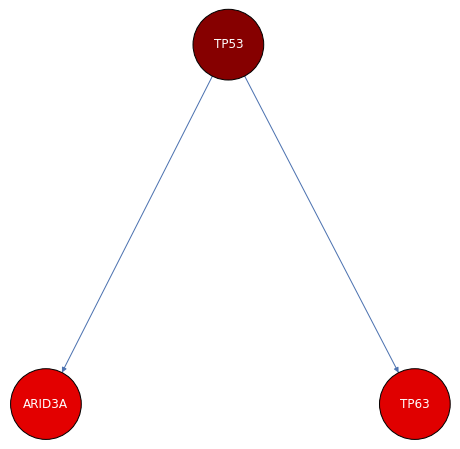

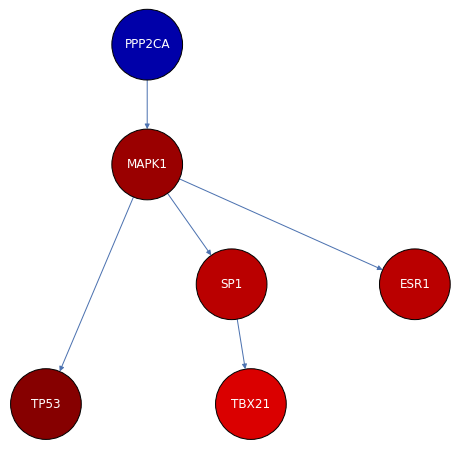

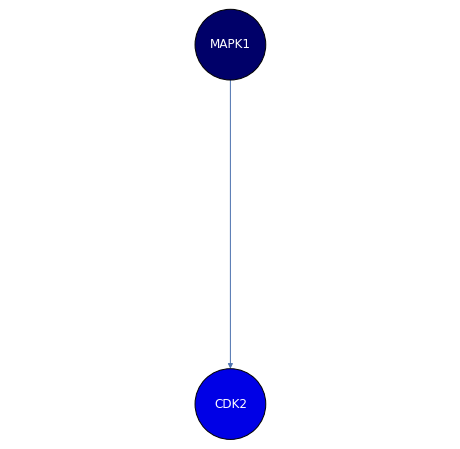

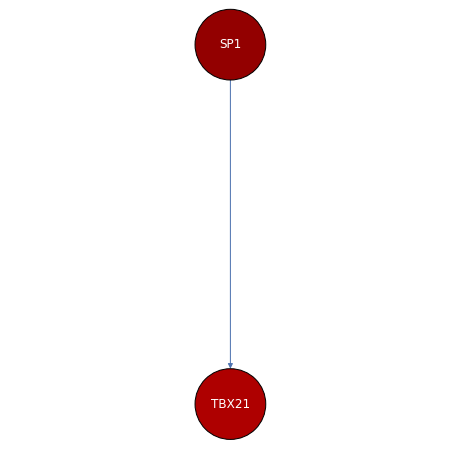

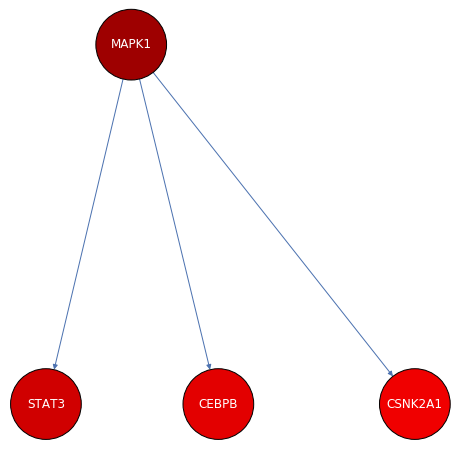

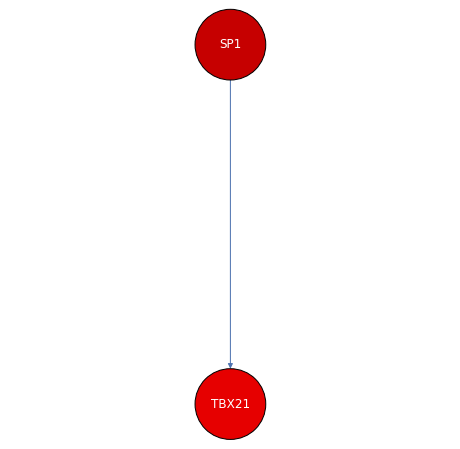

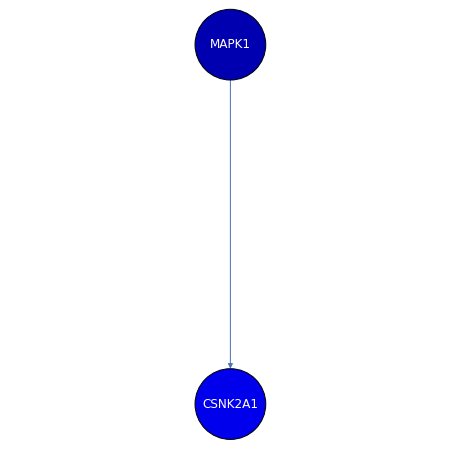

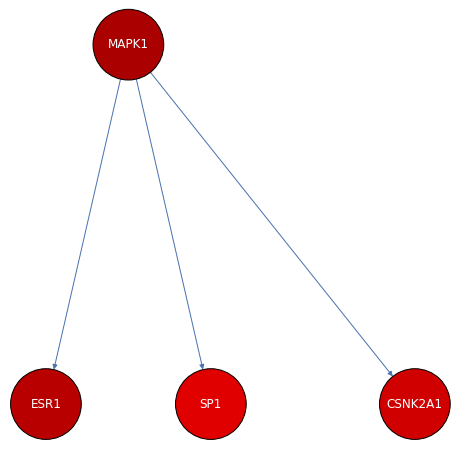

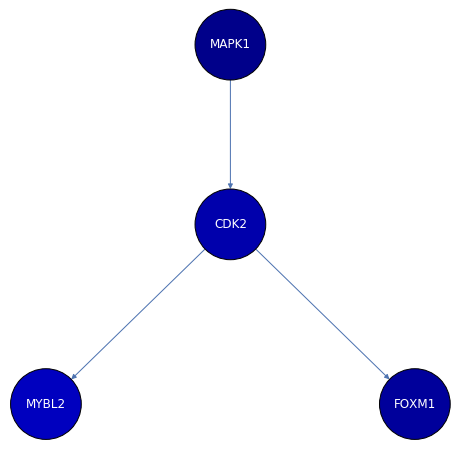

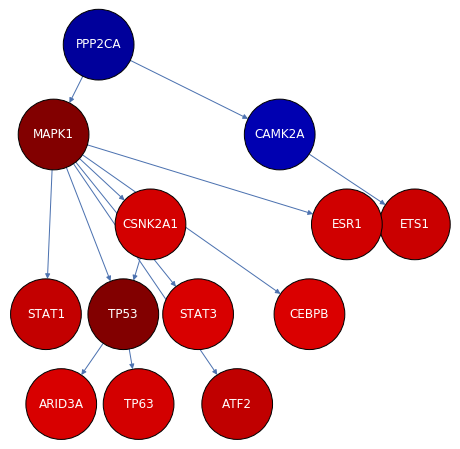

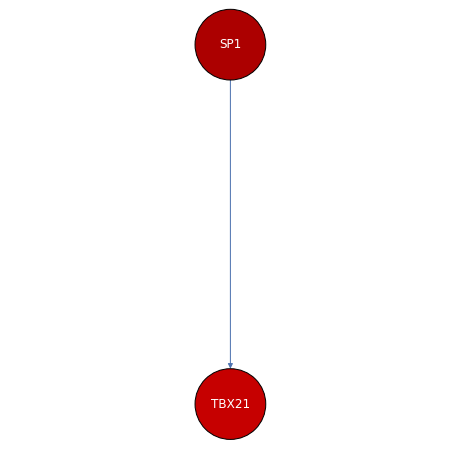

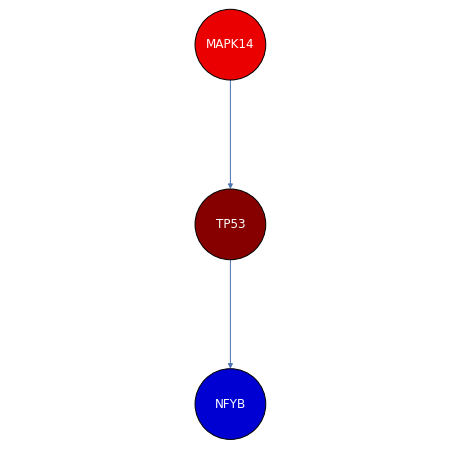

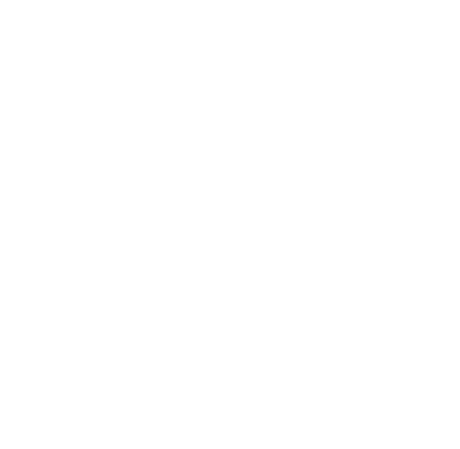

In [119]:
for i,net in enumerate(net_list):
    pos = nx.nx_pydot.graphviz_layout(net,'dot')
    values=[attr['act'] for node,attr in net.nodes(data=True)]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw(net,cmap=plt.get_cmap('seismic'), node_color=values, pos=pos, with_labels=True, node_size=5000,
        edgecolors='black', edge_color='b',vmin=-1, vmax=1,font_color='w')
    plt.savefig('final_plots_mcs/mfs_cluster_%s.png'%i)

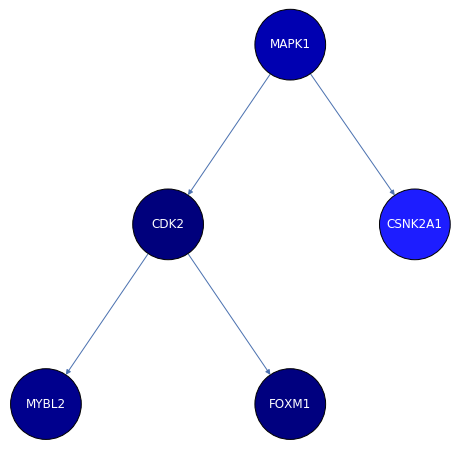

In [117]:
#for net in net_list:
pos = nx.nx_pydot.graphviz_layout(net_list[0],'dot')
values=[attr['act'] for node,attr in net_list[0].nodes(data=True)]
plt.figure(figsize=(8, 8))
plt.axis('off')
nx.draw(net_list[0],cmap=plt.get_cmap('seismic'), node_color=values, pos=pos, with_labels=True, node_size=5000,
        edgecolors='black', edge_color='b',vmin=-1, vmax=1,font_color='w')
plt.show()